# Sentiment Analysis for Individual Product Features

This notebook demonstrates how sentiment analysis can be used to evaluate opions about individual features of a product. For example, one might want to know how good (or bad) the battery or volume of a bluetooth speaker is. An naive approach would be to read multiple customer reviews. However, this can be exhausting, since there might be a lot of reviews for that product, from which only a small portion contain information about the relevant feature. Hence, it would be beneficial to get these information in a more compressed and easy to understand form.  

To overcome this issue, a sentiment analysis model is trained with Amazon reviews data. This model, a Long-Short-Term-Memory (LSTM) neural network, is then used to compute sentiment scores from multiple reviews that contain opinions about certain product features . The single scores are then aggregated and expressed as a distribution or e.g. single metric (mean).  

The steps involve:  
1. Create a dataset from Amazon reviews  
2. Clean and pre-process the raw text data  
3. Train a LSTM with TensorFlow using Keras API  
4. Extract the top product features  
5. Use the sentiment model to predict and aggregrate customer's opinions about the product features

# 1. Create a Dataset from Amazon Reviews

Luckily, we do not need to gather all the reviews by ourselves, we can simply use the Amazon review dataset provided by Julian McAuley from the University of California San Diego, which are available at http://jmcauley.ucsd.edu/data/amazon/. For this notebook I'm going to use the $5-core$ datasets from the categories:  
* Cell Phones and Accessories  
* Electronics  
* Home and Kitchen  
* Musical Instruments  
* Sports and Outdoors  
* Tools and Home Improvement


### 1.1 Import Files, Drop all Reviews with Neutral Rating and Convert Ratings to Binary Values

Essentially, we only care about the review text with the corresponding rating as label. Moreover, neutral ratings (3 stars) are removed, since they are hard to predict. To achieve the best performance, it is advised to convert the ratings into binary values. We already did a survey at our University where we asked people to infer the numerical rating from a given review text. The results clearly indicated that people typically can not distinguish between 1 and 2 star or 4 and 5 ratings. Hence, the ratings are combined into the two classes 0 (1 & 2 star ratings) and 1 (4 & 5 star ratings).

In [3]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = (12, 6)
plt.style.use('ggplot')
%matplotlib inline

os.chdir('D:/data/amzn_reviews/') # folder with the .gz files

In [5]:
files = os.listdir('dataset/')

data = pd.DataFrame()
for file in files:
    df = pd.read_json(('dataset/'+file), lines=True)
    df = df[['overall', 'reviewText']]
    df = df[df['overall'] != 3]
    df['class'] = np.where(df['overall'] >= 4, 1, 0)
    data = data.append(df)

Let's explore the length of the reviews in characters:

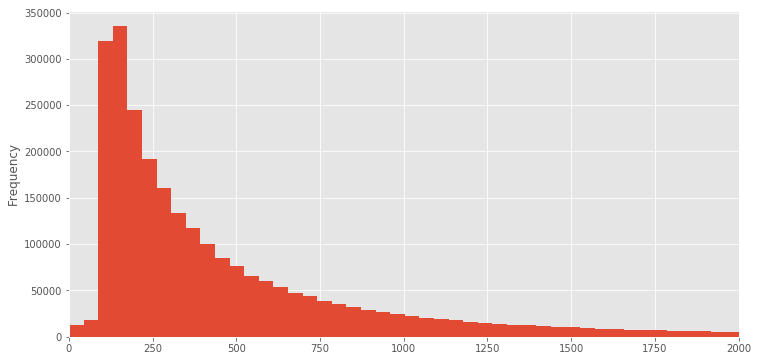

In [7]:
data['text_length'] = [len(text) for text in data['reviewText']]
data['text_length'].plot.hist(bins=750, xlim=(0, 2000));

### 1.2 Drop too Short and too Long Reviews
LSTM models required a fixed input size of the training examples. Therefore, all reviews have to be padded or truncated to the same length. The final model is used to predict sentiments from sentences and thus, too long reviews are omitted. On the other hand, too short reviews might not contain enough information. Here, I decided to use reviews with the length of $100 < \text{#characters} < 700$.

In [8]:
data = data[(data['text_length'] > 100) & (data['text_length'] < 700)]
data['class'].value_counts()

1    1752813
0     204202
Name: class, dtype: int64

### 1.3 Create a Balanced Dataset

We can see that only about 10% of the reviews are negative. Training a model with such a heavily biased dataset will be problematic. Since we have around 2 mio reviews here, the easiest way is to create an equally balanced dataset by randomly selecting the same amount from the positive reviews as we have negative ones.

In [9]:
selected_data = data[data['class'] == 0]
selected_data = selected_data.append(data[data['class'] == 1].sample(len(data[data['class'] == 0]),
                                                                      random_state=777))
selected_data.drop(columns=['text_length'], inplace=True)
selected_data = selected_data.sample(frac=1, random_state=777) #shuffle data

# 2. Clean and Pre-Process the Raw Text Data

The raw text data from the reviews are way too messy to use them directly. The code below applies various text pre-processing steps, including:  
* remove stopwords ('that', 'so', 'and', etc.)  
* apply lemmatization, i.e. reducing a word to its base form. E.g. 'handle', 'handling' and 'handles' are converted to 'handle'. In contrast with stemming, lemmatization is more accurate but also computational more expensive. For more information see https://nlp.stanford.edu/IR-book/html/htmledition/stemming-and-lemmatization-1.html .  
* remove all unnecessary (special) characters and whitespaces and with regular expressions (regex)  

To perform this task the popular NLTK library is used.  
Note: If you have not used NLTK before you will get a LookupError. In this case you need to use `import nltk` followed by `nltk.download('wordnet')`, in order to download the NLTK files. 

In [10]:
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from string import punctuation
import re

def clean_text(text):
    '''
    function to clean and format the data, outputs a list
    '''
    text = text.lower().split()

    # remove stop words ('that', 'so', 'and', etc.)
    stopwords_lst = set(stopwords.words("english"))
    text = [w for w in text if not w in stopwords_lst]
        
    # lemmatization
    text = [WordNetLemmatizer().lemmatize(word, pos='v') for word in text]    
    text = " ".join(text)
    
    # clean the text with regex
    text = re.sub(r"<br />", " ", text)    
    text = re.sub(r"[^a-z]", " ", text)
    text = re.sub(r"   ", " ", text)
    text = re.sub(r"  ", " ", text)
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " + ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\=", " = ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r":", " : ", text)
    text = re.sub(r" e g ", " eg ", text)
    text = re.sub(r" b g ", " bg ", text)
    text = re.sub(r" u s ", " american ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r"e - mail", "email", text)
    text = re.sub(r"j k", "jk", text)
    text = re.sub(r"\s{2,}", " ", text)
    
    # remove punctuation from text
    text = ''.join([c for c in text if c not in punctuation])
    return (text)


cleaned = []
for review in selected_data['reviewText']:
    cleaned.append(clean_text(review))

### 2.1 Check the Results
To demonstrate the results of the pre-processing steps:

In [12]:
print('Original review: \n {}'.format(selected_data['reviewText'].iloc[0]))
print('Cleaned review: \n {}'.format(cleaned[0]))

Original review: 
 Klein makes the very best screwdrivers period!  This is the nicest set I could find and I have tried them all.  Very nice selection at a good price, way to go Klein!
Cleaned review: 
 klein make best screwdrivers period nicest set could find try all nice selection good price way go klein 


Now, finally merge the cleaned reviews with the numerical ratings:

In [13]:
data = selected_data.copy()
data['reviewText'] = cleaned
data.reset_index(inplace=True, drop=True)

### 2.2 Tokenization, padding and split into train/test data
Obviously, we can not use strings as input for a neural network. Popular methods to convert them into numerical values are e.g. Bag-of-Words or TF-IDF. However, both approaches do not really suit neural networks. A more powerful approach is to use an embedding layer in the neural network, which requires already tokenized documents of the same length. Tokenization is a simple method of converting text into numerical values by indexing every token (word) and transforming the text to word vectors.  

Since the embedding layer is going to index every unique word, it is beneficial to limit the amounts of words to the most frequent ones. Here, I set the limit to the most frequent 30000 words. LSTM also required fixed input size vectors and thus, the reviews are padded (extended with 0's) or truncated to 101 words.  

Finally, the dataset is split into 75% train, 10% validation and 15% test data.

In [14]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

# train/test/val split
train, remain = train_test_split(data, test_size=0.25, shuffle=False)
test, validation = train_test_split(remain, test_size=0.4, shuffle=False)


# Tokenziation
max_words = 30000

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(data['reviewText'])
train_seq = tokenizer.texts_to_sequences(train['reviewText'])
test_seq = tokenizer.texts_to_sequences(test['reviewText'])
val_seq = tokenizer.texts_to_sequences(validation['reviewText'])


# padding reviews to same length
max_review_length = 101

max_review_length = max([len(lst) for lst in (train_seq+test_seq+val_seq)])
X_train = pad_sequences(train_seq, maxlen=max_review_length)
X_test = pad_sequences(test_seq, maxlen=max_review_length)
X_val = pad_sequences(val_seq, maxlen=max_review_length)

y_train = train['class']
y_val = validation['class']


# verify results
print("Shape X_train", X_train.shape)
print("Shape y_train", y_train.shape)
print("Shape X_test", X_test.shape)
print("Shape y_test", test['class'].shape)
print("Shape X_val", X_val.shape)
print("Shape y_val", y_val.shape)

Using TensorFlow backend.


Shape X_train (306303, 101)
Shape y_train (306303,)
Shape X_test (61260, 101)
Shape y_test (61260,)
Shape X_val (40841, 101)
Shape y_val (40841,)


# 3. Train a LSTM with TensorFlow using Keras API

The architecture of Long-Short-Term-Memory (LSTM) neural networks is highly recommended for sequential data, such as e.g. text. It allows to capture time dependent structure, i.e. not only regarding two adjacent words but also more distinct relationships. They are a type of Recurrent Neural Networks (RNN), with the purpose of overcoming the vanishing gradient problem by introducing the more sophisticated LSTM cells.  


### 3.1 Define the Model


Note: I'm using the for Nvidia GPUs optimized `CuDNNLSTM` cells here. This requires that you have a Nvidia GPU with installed CUDA and CuDNN drivers. As a result, training will be much faster compared to the regular LSTM cells. On the downside, the `CuDNNLSTM` cells do not allow for dropout. While the dropout between the layers can be implementent by adding a `Dropout` layer after the LSTM layer, there is unfortunately no way to implement the recurrent dropout, i.e. the dropout for the internal states. For this particular purpose here, I've found that there is actually no difference. However, if you don't have access to a Nvidia GPU or want to use the recurrent dropout, simply replace the keras `CuDNNLSTM` cells with the regular `LSTM` cells from `tensorflow.keras.layers`. 

In [24]:
import tensorflow as tf
from tensorflow.keras.layers import CuDNNLSTM, LSTM, Embedding, Dropout, Input, Dense
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint

def lstm_model(n_hidden=[100, 50, 25],
               dropout_rate=0.2,
               embedding_dim=100,
               regularization=1e-6,
               learning_rate=0.0001,
               loss_function='binary_crossentropy',
               activation='sigmoid',
               initializer='he_normal'):
        
    input_layer = Input(shape=(max_review_length, ),
                        dtype='int32', 
                        name="Input_Layer")
    embedding_layer = Embedding(input_dim=max_words,
                                output_dim=embedding_dim,
                                input_length=max_review_length,
                                embeddings_initializer=initializer,
                                embeddings_regularizer=l2(regularization),
                                name="Embedding_Layer")(input_layer)
    x = CuDNNLSTM(units=n_hidden[0],
                   return_sequences=True,
                   unit_forget_bias=True,
                   kernel_initializer=initializer,
                   kernel_regularizer=l2(regularization),
                   name="LSTM_Layer_0")(embedding_layer)
    x = Dropout(dropout_rate,
                name="Dropout_Layer_0")(x)
    for i in range(len(n_hidden)-2):
        x = CuDNNLSTM(units=n_hidden[i+1],
                       return_sequences=True,
                       unit_forget_bias=True,
                       kernel_initializer=initializer,
                       kernel_regularizer=l2(regularization),
                       name=("LSTM_Layer_"+str(i+1)))(x)
        x = Dropout(dropout_rate,
            name=("Dropout_Layer_"+str(i+1)))(x)
    x = CuDNNLSTM(units=n_hidden[-1],
                   return_sequences=False,
                   kernel_initializer=initializer,
                   kernel_regularizer=l2(regularization),
                   name=("LSTM_Layer_"+str(len(n_hidden)-1)))(x)
    x = Dropout(dropout_rate,
                name=("Dropout_Layer_"+str(len(n_hidden)-1)))(x)
    output_layer = Dense(units=1,
                        activation=activation,
                        kernel_initializer=initializer,
                        name="Output_Layer")(x)
    
    model = tf.keras.Model(inputs=input_layer, outputs=output_layer)
    model.summary()
    model.compile(optimizer=Adam(lr=learning_rate),
              loss=loss_function,
              metrics=['accuracy'])    
    return model



def fit_model(model,
             batch_size=128,
             n_epochs=10):
    
    callbacks = [ModelCheckpoint(filepath='checkpoints/model_checkpoint.h5',
                                 monitor='val_loss', 
                                 save_best_only=True)]
    
    model.fit(X_train, y_train,
              batch_size=batch_size,
              epochs=n_epochs,
              validation_data=(X_val, y_val),
              callbacks=callbacks,
              verbose=1)
    
    
model = lstm_model()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input_Layer (InputLayer)     (None, 101)               0         
_________________________________________________________________
Embedding_Layer (Embedding)  (None, 101, 100)          3000000   
_________________________________________________________________
LSTM_Layer_0 (CuDNNLSTM)     (None, 101, 100)          80800     
_________________________________________________________________
Dropout_Layer_0 (Dropout)    (None, 101, 100)          0         
_________________________________________________________________
LSTM_Layer_1 (CuDNNLSTM)     (None, 101, 50)           30400     
_________________________________________________________________
Dropout_Layer_1 (Dropout)    (None, 101, 50)           0         
_________________________________________________________________
LSTM_Layer_2 (CuDNNLSTM)     (None, 25)                7700      
__________

About the model:  
Dropout and $l2 - norm$ regularization is used to prevent overfitting. To achieve outputs between 0 and 1, the final activation function is *sigmoid* and for the loss function I've choosen *binary crossentropy*. The variables are initialized by drawing samples from a truncated normal distribution with the *He normal initializer*. Training is done with *Adam Optimizer*, a more sophisticated form of stochastic gradient descent. 

### 3.2 Train the model

Train on 306303 samples, validate on 40841 samples
Epoch 1/5
306303/306303 [==============================] - 127s 415us/step - loss: 0.3495 - acc: 0.8496 - val_loss: 0.2958 - val_acc: 0.8759
Epoch 2/5
306303/306303 [==============================] - 125s 409us/step - loss: 0.2746 - acc: 0.8879 - val_loss: 0.2844 - val_acc: 0.8803
Epoch 3/5
306303/306303 [==============================] - 126s 410us/step - loss: 0.2505 - acc: 0.8975 - val_loss: 0.2828 - val_acc: 0.8823
Epoch 4/5
306303/306303 [==============================] - 125s 408us/step - loss: 0.2320 - acc: 0.9060 - val_loss: 0.2926 - val_acc: 0.8813
Epoch 5/5
306303/306303 [==============================] - 124s 406us/step - loss: 0.2141 - acc: 0.9135 - val_loss: 0.2936 - val_acc: 0.8811


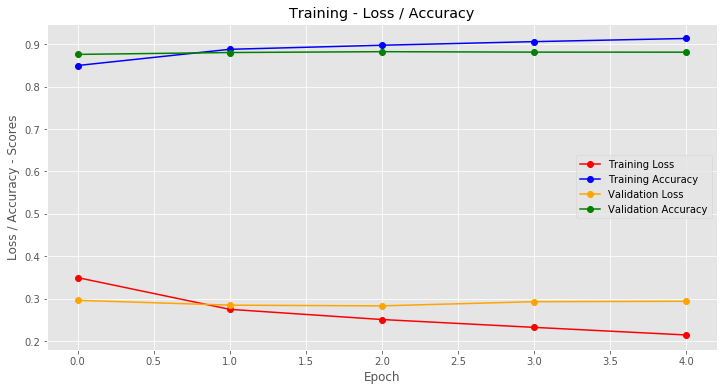

In [25]:
def plot_loss(model):
    epochs = model.history.epoch
    plt.figure()
    plt.plot(epochs, model.history.history['loss'], 
             'bo', label='Training Loss', linestyle='-', color='red')
    plt.plot(epochs, model.history.history['acc'],
             'bo', label='Training Accuracy', linestyle='-', color='blue')
    plt.plot(epochs, model.history.history['val_loss'],
             'bo', label='Validation Loss', linestyle='-', color='orange')
    plt.plot(epochs, model.history.history['val_acc'],
             'bo', label='Validation Accuracy', linestyle='-', color='green')
    plt.xlabel('Epoch')
    plt.ylabel('Loss / Accuracy - Scores')
    plt.title('Training - Loss / Accuracy')
    plt.legend()
    plt.show();
    
    
fit_model(model=model, n_epochs=5)

plot_loss(model)

### 3.3 Evaluate the Results

An advantage of binary classifications tasks is that a wide range of possible evaluation metrics is available. The most common and easy to interprete metric here is accuracy, i.e. how often the model predicts the correct class label on the test dataset. However, this is not the only metric of interest. Since the input dataset is perfectly equal distributed, the goal here is to achieve a balanced output, i.e. no bias towards negative or positive ratings. As we can see from the confusion matrix, there is only a very little bias torwards positive ratings, which is acceptable for this data and model architecture.

Accuracy-Score is 0.8834
Recall-Score is 0.8884
Precision-Score is 0.8797
F1-Score is 0.884
ROC AUC-Score is 0.9514


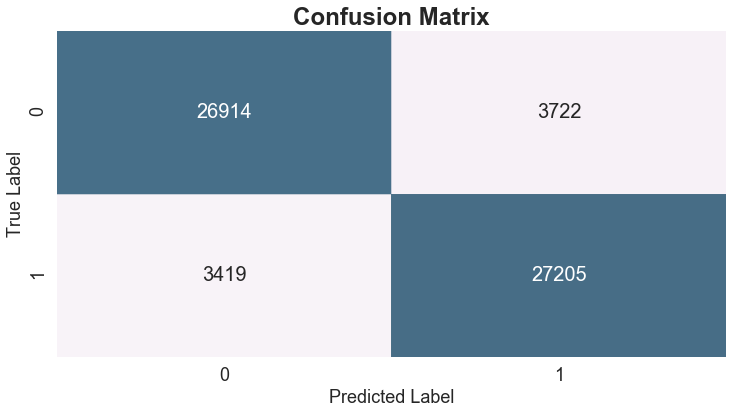

In [178]:
from sklearn import metrics

def plot_confusion_matrix(y_true, y_pred):
    sns.heatmap(metrics.confusion_matrix(y_true, y_pred), annot=True, 
                cmap="PuBu", alpha=0.7, cbar=False, fmt='.0f',
                annot_kws={"size": 20})    
    plt.xlabel('Predicted Label', fontsize=18)    
    plt.ylabel('True Label', fontsize=18)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.title('Confusion Matrix', fontweight='bold', fontsize=24)
    plt.show();
    
    
predictions = model.predict(X_test)
y_pred = np.round(predictions).ravel().astype(int)
y_true = test['class']

metrics_dict = {}
metrics_dict['Accuracy'] = metrics.accuracy_score(y_true, y_pred)
metrics_dict['Recall'] = metrics.recall_score(y_true, y_pred)
metrics_dict['Precision'] = metrics.precision_score(y_true, y_pred)
metrics_dict['F1'] = metrics.f1_score(y_true, y_pred)
metrics_dict['ROC AUC'] = metrics.roc_auc_score(y_true, predictions)


for key, value in metrics_dict.items():
    print('{0}-Score is {1}'.format(key, np.round(value, 4)))    

plot_confusion_matrix(y_true, y_pred)

Visualizing the output distribution might be helpful to better understand the predictions. Remembering that we used the sigmoid function, which squashes all the values between 0 and 1, while tending to shift the values torwards more extreme values. This behaviour does suit our needs and can be clearly seen from the histogram below.

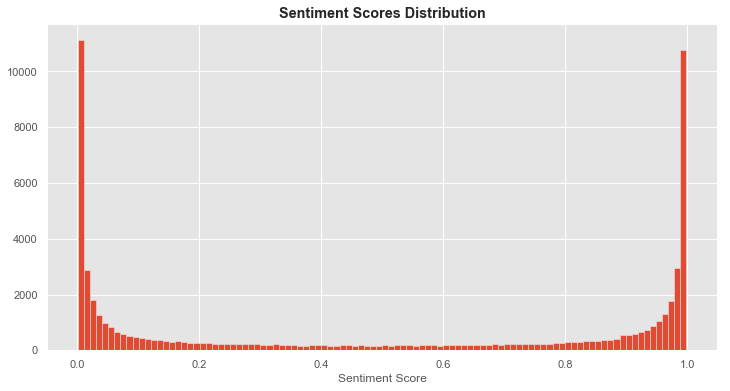

,overall,reviewText,class,predictions,prediction_class,error
306303,4,okay geeky cool thing button cord pause playba...,1,0.997059,1,0
306304,5,like it small still like it bunch blink option...,1,0.824071,1,0
306305,5,get gift teenager really put tablet wringer ca...,1,0.996410,1,0
306306,1,order zune dock get sierra wireless u cock cra...,0,0.006476,0,0
306307,1,title say all good deal wonder good ones stop ...,0,0.032145,0,0
306308,5,want get hand first aid emergencies also use i...,1,0.950500,1,0
306309,5,basically white glass marbles high specific gr...,1,0.159258,0,1
306310,1,mac computer avoid product look like apple usb...,0,0.024214,0,0
306311,1,nice looking works like crap sounds like alway...,0,0.002674,0,0
306312,1,one get work break couple days simply stop wor...,0,0.004052,0,0


In [180]:
def plot_scores_dist(predictions_df):
    plt.style.use('ggplot')
    predictions_df['predictions'].hist(bins=100)
    plt.xlabel('Sentiment Score')
    plt.title('Sentiment Scores Distribution', fontweight='bold')
    plt.show();
    
    
predictions_df = test.copy()
predictions_df['predictions'] = predictions
predictions_df['prediction_class'] = y_pred0
predictions_df['error'] = abs(y_true-y_pred)


plot_scores_dist(predictions_df)

predictions_df.head(10)

### 3.4 Save the model
Finally, the trained model is saved as a pickle file, which can be later reused to get predictions from it. We also need to save the tokenizer, since its internal dictionary is based on the reviews from the pre-processing step. 

In [260]:
import pickle
from tensorflow.keras.models import save_model

# save the model:
save_model(model, filepath='model/final_model.h5')

# save the tokenizer:
with open('model/tokenizer.pickle', 'wb') as file:
    pickle.dump(tokenizer, file)

In [ ]:
# # If you want to load the trained model/tokenizer simply uncomment these lines:

# from keras.models import load_model

# # load the model:
# model = load_model('model/final_model.h5')

# # load the tokenizer:
# with open('model/tokenizer.pickle', 'rb') as file:
#     tokenizer = pickle.load(file)

### 3.5 Inferencing

The `inference` function takes as input the fitted model, the fitted tokenizer and the raw text, from which a sentiment score between 0 and 1 is predicted.

In [142]:
def inference(raw_text, model=model, tokenizer=tokenizer):
    seq = tokenizer.texts_to_sequences([clean_text(raw_text)])
    pad = pad_sequences(seq, maxlen=max_review_length)
    return float(model.predict(pad))

We can check the sentiment model's predictive power by inputting arbitrary strings. I've created three short examples for which an sentiment score is provided:

In [145]:
pos_text = 'very good quality and fast delivery'
neg_text = 'arrived broken, no answer from support, never again'
neu_text = 'arrived too late, but quality is ok'

print('Positive text score: {:.4f}'.format(inference(pos_text)))
print('Negative text score: {:.4f}'.format(inference(neg_text)))
print('Neutral text score: {:.4f}'.format(inference(neu_text)))

Positive text score: 0.9347
Negative text score: 0.0667
Neutral text score: 0.2220


# 4. Extract Relevant Keywords and Sentences

A keyword here is a noun that refers to a certain product feature, e.g. volume or battery for a bluetooth speaker. To extract these keywords, the word frequency of nouns in the reviews is computed and the top k-keywords with the highest frequency are selected. 

### 4.1 Import Reviews

To demonstrate how it works I've simply selected all the reviews for a product from the above used Amazon dataset. Each product on Amazon has an unique identification number, the ASIN, which is used to extract the reviews from the dataset.  

Since the sentiment scores are aggregated from multiple reviews, only keywords that appear often enough in the reviews should be considered.  
As an example I've selected an MP3 Player that is no more available (it's 2019), but the product description page can still be found here: https://www.amazon.com/gp/product/B002MAPRYU . This one has 1374 reviews, which should be enough to analyze multiple reviews per keyword.

In [274]:
asin = 'B002MAPRYU'

reviews = pd.read_json(('dataset/reviews_Electronics_5.json.gz'), lines=True)
reviews = reviews[reviews['asin'] == asin]['reviewText']

### 4.2 Tokenize the Reviews and Apply Part-of-Speech Tagging

In order to acutally get the nouns from the raw reviews a method called Part-of-Speech (POS) Tagging is used, which determines the word class for each word. Once again, NLTK is used to achieve this. The result is a ('word', 'tag')-tuple for each word. Since we are interested in nouns, only words with the 'NN' tag are choosen to keep. From these nouns are then the most 20 frequent ones, with at least 3 characters, selected.  

Since the sentiment analysis is performed on sentences, the `tok_pos` function also returns tokenized sentences, i.e. the reviews are splitted into single sentences.  

Note: If you have not used NLTK before you will get a LookupError. In this case you need to use `import nltk` followed by `nltk.download('averaged_perceptron_tagger')`, in order to download the NLTK files. 

In [278]:
from keras.preprocessing.text import text_to_word_sequence
from nltk import pos_tag, FreqDist
from nltk.tokenize import sent_tokenize
from collections import OrderedDict

def tok_pos(reviews):
    '''
    Get the Part-of-Speech tag for each word and tokenize (split) the reviews into sentences
    Input: list / pd.series with raw reviews
    Output: (POS-tagged keywords, tokenized sentences)-tuple
    '''
    reviews_pos = []
    reviews_sent = []
    for review in reviews:
        tok_review = text_to_word_sequence(clean_text(review))
        reviews_pos.append(pos_tag(tok_review))
        reviews_sent.append(sent_tokenize(review))
        
    reviews_sent = [sent for element in reviews_sent for sent in element] # flatten list
    return reviews_pos, reviews_sent


def get_tagged_words(reviews_pos, tag='NN'):
    '''
    Input: list with (word, POS-tag)-tuple
    returns list with words for a specific POS-tag, e.g. 'NN' = nouns
    '''
    word_lst = []
    for rev in reviews_pos:
        word_lst.append([pos[0] for pos in rev if (pos[1] == tag)])
    return [word for element in word_lst for word in element]


def get_top_k(word_lst, k=20, min_length=3):
    '''
    Returns the k most common words of a list
    Set min_length to exlcude words shorter than min_length
    '''
    words_freq = FreqDist(word_lst)
    words_freq = {word: count for word, count in words_freq.items() if len(word) >= min_length}
    words_freq = OrderedDict(sorted(words_freq.items(), key = lambda x: x[1], reverse=True))
    return list(words_freq.keys())[:k]


reviews_pos, reviews_sent = tok_pos(reviews)
nouns = get_tagged_words(reviews_pos)
top20 = get_top_k(nouns)

print('The 20 most frequent nouns are: \n {}'.format(top20))

The 20 most frequent nouns are: 
 ['player', 'clip', 'use', 'music', 'work', 'battery', 'time', 'sansa', 'card', 'quality', 'sound', 'device', 'price', 'unit', 'life', 'thing', 'play', 'charge', 'file', 'computer']


# 5. Use the Model to Predict Sentiments for the Top20 Keywords 

In the final step all the sentences containing each of the keywords are identified and the sentiment model is used to predict the sentiment for each of these sentences.

In [279]:
def predict_sentiment(sentences, keywords):
    '''
    predict the sentiment scores from the 'sentences' list 
    for each keyword of the 'keywords' list
    returns a dictonary with all the sentiment scores per keywords
    '''
    sentiments = {}
    for word in keywords:
        scores = []
        for review in sentences:
            if word in review.lower():
                scores.append(inference(clean_text(review)))

        sentiments[word] = scores
    return sentiments

sentiments = predict_sentiment(reviews_sent, top20)

Let's visualize the sentiment distribution of keyword:

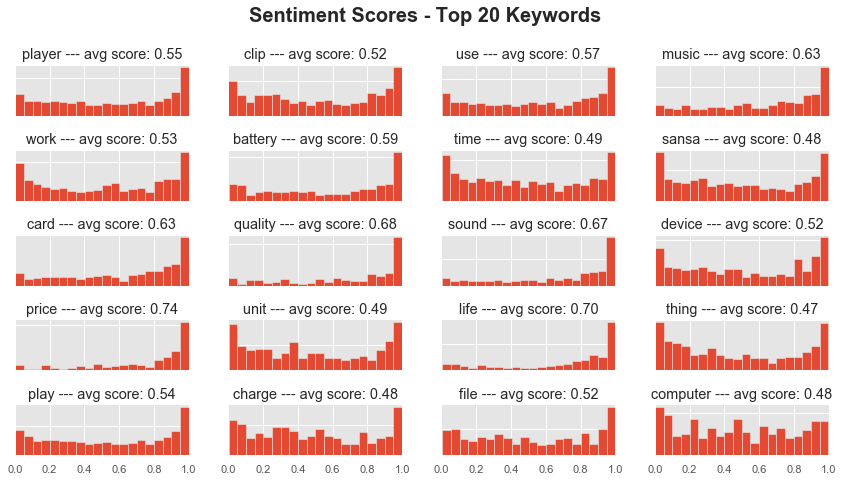

In [281]:
def plot_scores(sentiments):
    fig = plt.figure(figsize=(12, 7))

    for num, word in enumerate(sentiments.keys()):
        ax = fig.add_subplot(5, 4, num+1)
        ax.hist(sentiments.get(word), bins=20)
        ax.set_xlim(0, 1)
        ax.set_title('{} --- avg score: {:.2f}'.format(word, 
                                                     np.mean(sentiments.get(word))))
        ax.set_yticklabels([])
        if num < 16:
            ax.set_xticklabels([])

    plt.suptitle('Sentiment Scores - Top 20 Keywords', fontsize=20, fontweight='bold')
    fig.tight_layout(rect=[0, 0.03, 1, 0.92])
    plt.show()
    
plot_scores(sentiments)

A short overview of the descriptive statistics:

In [247]:
sentiments_df = pd.DataFrame.from_dict(sentiments, orient='index').T
sentiments_df.describe()

,player,clip,use,music,work,battery,time,sansa,card,quality,sound,device,price,unit,life,thing,play,charge,file,computer
count,1714.000000,1130.000000,1709.000000,895.000000,882.000000,545.000000,534.000000,639.000000,495.000000,381.000000,666.000000,397.000000,330.000000,323.000000,310.000000,792.000000,2325.000000,366.000000,353.000000,251.000000
mean,0.552330,0.519260,0.566596,0.634279,0.529338,0.586408,0.488334,0.484859,0.629121,0.684929,0.673366,0.519438,0.740294,0.486903,0.696643,0.465440,0.540271,0.482144,0.524758,0.476190
std,0.327222,0.333287,0.327943,0.307808,0.343465,0.337812,0.329374,0.334946,0.314897,0.318162,0.315985,0.339374,0.289015,0.333859,0.319271,0.340900,0.331272,0.314666,0.326744,0.310803
min,0.001649,0.001649,0.001649,0.002401,0.001788,0.002611,0.001649,0.001649,0.002943,0.001649,0.001849,0.001788,0.001849,0.003525,0.005624,0.001849,0.001649,0.001849,0.005361,0.001742
25%,0.252385,0.213888,0.263199,0.375151,0.187083,0.277746,0.188943,0.180812,0.369578,0.455298,0.419755,0.208980,0.566497,0.182407,0.469948,0.142466,0.237602,0.224449,0.235315,0.206700
50%,0.570544,0.517547,0.599413,0.717240,0.554704,0.652030,0.470430,0.453695,0.727506,0.816369,0.803041,0.483299,0.882301,0.460293,0.829028,0.407384,0.546645,0.460217,0.503039,0.472399
75%,0.873608,0.848875,0.882655,0.910204,0.861183,0.917884,0.801759,0.825076,0.916023,0.967636,0.959458,0.850611,0.970176,0.831679,0.965907,0.815065,0.867723,0.772229,0.835137,0.728547
max,0.998586,0.998220,0.998586,0.998522,0.998586,0.998425,0.998387,0.998120,0.998522,0.998387,0.998200,0.997651,0.998586,0.998220,0.998425,0.998387,0.998586,0.998387,0.998341,0.998140


# Usage

For example, one could:  

* build a web-scraper that downloads all the reviews for a certain product from a website and use the proposed model to get aggregated metrics about the desired product features. In fact, all you need is a set of reviews that contain a reasonable amount of reviews about the features.  
* use the sentiment scores to compare various products with regard to their features, e.g. product A has a better battery but worse volume than product B.  
* find a product with the best feature among a large set of available products, e.g. find the speaker with the best battery.  
* quickly evaluate what customers like and don't like about your own or the competitors products.  

etc...




# Outlook

There is still a lot of potential to optimize the result, e.g.: 

* use more reviews, possibly include reviews from other data ressources besides Amazon.  
* build the model upon a pre-trained word2vec model  
* use a more sophisticated pre-processing procedure and model 
* generate additional input-features from the raw text  
* extract keywords with a latent Dirichlet allocation (LDA) model instead of POS tagging  

However, verifying the results of sentiment models is definitley not straightforward. While accurarcy and other metrics might not be that difficult to optimize, they do not account the complex structures of natural language such as sarcasm, fake reviews and mislabeled training data (some people indeed think that a 1-star review is the best rating and thus, they write a very positive text which has a very negative rating). 

In [267]:
% load_ext watermark
% watermark -d -v -iv -p keras,nltk

tensorflow 1.12.0
sklearn    0.20.2
pandas     0.23.4
numpy      1.16.2
matplotlib 2.2.2
re         2.2.1
scipy      1.0.0
seaborn    0.9.0
2019-05-10 

CPython 3.6.4
IPython 6.2.1

keras 2.2.4
nltk 3.2.5
